# Initial installations


In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install invoice2data
!pip install pdftotext

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 35 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (2,590 kB/s)
debconf: unable to initi

**Read the input invoice**

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

file=r'/content/sample1_2.jpg'
img = cv2.imread(file,0)
img.shape

(1686, 1238)

**Thresholding and inverting  image**

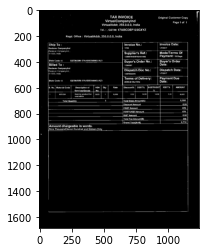

In [ ]:
thresh,img_bin = cv2.threshold(img,160,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

img_bin = 255-img_bin
cv2.imwrite('cv_inverted.png',img_bin)
plotting = plt.imshow(img_bin,cmap='gray')
plt.show()


**Finding vertical and horizontal lines**

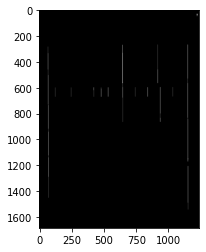

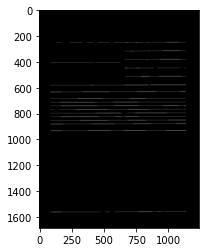

In [ ]:

kernel_len = np.array(img).shape[1]//100
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)
cv2.imwrite("vertical.jpg",vertical_lines)
plotting = plt.imshow(image_1,cmap='gray')
plt.show()

image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)
cv2.imwrite("horizontal.jpg",horizontal_lines)
plotting = plt.imshow(image_2,cmap='gray')
plt.show()


**Sort Contours and process the image and save it in a excel sheet**

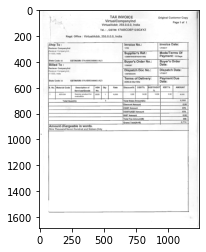

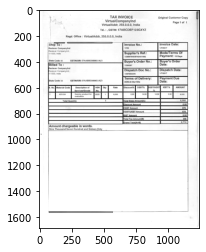

[[77, 1559, 492, 7]]
[[[1220, 13, 9, 56]], [[220, 249, 346, 7], [117, 251, 81, 5], [921, 252, 229, 63], [649, 252, 269, 65]], [[921, 318, 229, 63], [650, 318, 268, 65]], [[921, 384, 229, 64], [650, 384, 268, 65], [73, 409, 572, 172], [922, 450, 228, 62], [650, 450, 268, 63]], [[922, 515, 228, 63], [650, 515, 268, 64]], [[1038, 582, 112, 49], [941, 582, 94, 49], [844, 582, 93, 49], [747, 583, 93, 48], [651, 583, 93, 49], [538, 583, 109, 49], [483, 583, 51, 49], [427, 583, 53, 49], [251, 584, 172, 49], [128, 584, 120, 49], [74, 584, 51, 49]], [[1038, 634, 112, 49], [941, 634, 94, 49], [844, 634, 93, 49], [747, 635, 93, 48], [651, 635, 93, 49], [538, 635, 109, 49], [484, 636, 50, 48], [427, 636, 53, 48], [251, 636, 173, 49], [128, 636, 120, 49], [74, 637, 51, 48]], [[941, 686, 209, 25], [651, 686, 286, 25], [74, 687, 574, 26], [941, 714, 209, 25], [651, 714, 286, 25], [74, 715, 574, 26], [941, 742, 209, 25], [651, 742, 286, 26], [75, 743, 573, 26], [941, 770, 209, 25], [651, 770, 286, 53]

In [ ]:

img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite("img_vh.jpg", img_vh)
bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)
plotting = plt.imshow(bitnot,cmap='gray')
plt.show()

contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    return (cnts, boundingBoxes)

contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]

mean = np.mean(heights)

box = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
        
plotting = plt.imshow(image,cmap='gray')
plt.show()
row=[]
column=[]
j=0

for i in range(len(box)):    
        
    if(i==0):
        column.append(box[i])
        previous=box[i]    
    
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]            
            
            if(i==len(box)-1):
                row.append(column)        
            
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
            
print(column)
print(row)

countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]

center=np.array(center)
center.sort()
print(center)

finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)


outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2, cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=2)
                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner +" "+ out
            outer.append(inner)

arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row), countcol))
print(dataframe)
data = dataframe.style.set_properties(align="left")
data.to_excel("output.xlsx")

In [ ]:
!pip install -U CamelotPro

     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 5.6MB 39.5MB/s 
     |████████████████████████████████| 2.7MB 46.8MB/s 
  Created wheel for PyPDF2: filename=PyPDF2-1.26.0-cp36-none-any.whl size=61086 sha256=9a035a44dc20668fd7a786154f2243ccbb17ea7f1c4824be68a15e65a87058fd
  Stored in directory: /root/.cache/pip/wheels/53/84/19/35bc977c8bf5f0c23a8a011aa958acd4da4bbd7a229315c1b7
Successfully built PyPDF2


# APIs which we plan to use

In [ ]:

api_key = "QmMQ0t73wR5LZQ6074JmS87sngWEWiSm74ZPNKPM"
from camelot_pro.gopro import GoPro
validate = GoPro(api_key=api_key).validate_api_key()
print(validate.api_usage)
from camelot_pro import read_pdf
input_file = "sample1_2.jpg"
pro_tables = read_pdf(input_file, flavor="CamelotPro", pro_kwargs={'api_key': api_key, 'dup_check': False})

[Info]: Only 6 Credits Left
{'credits': 15, 'queued': 0, 'used': 9}


In [ ]:
pro_tables.JobStatus

'Success'

In [ ]:
pro_tables
pro_tables.__dict__

{'JobStatus': 'Success',
 'Pages': 1,
 '_tables': [<Table shape=(5, 2)>,
  <Table shape=(8, 4)>,
  <Table shape=(2, 10)>]}

In [ ]:
pro_tables[2].df

,0,1,2,3,4,5,6,7,8,9
0,No.,Material Code,Description of Services/Goods,HSN No.,Qty,Rate,Discount%,CGST%,SGST/UGST %,IGST %
1,,AB1234,Dummy product for evaluation,8528,1,"8,000",0.00,14.00,14.00,0.00


In [ ]:
!pip install cloudmersive-ocr-api-client

     |████████████████████████████████| 40kB 1.5MB/s 
  Created wheel for cloudmersive-ocr-api-client: filename=cloudmersive_ocr_api_client-3.0.1-cp36-none-any.whl size=98848 sha256=25e88481b52e0f5d2ded0eae9716b96e620dff61d805d7e15caf3fe1f3da5f67
  Stored in directory: /root/.cache/pip/wheels/f1/ca/9e/290f1b5f0bfe5f092d4ce18c9c032d893111c120f28e9d72a8
Successfully built cloudmersive-ocr-api-client


In [ ]:
import cloudmersive_ocr_api_client
from cloudmersive_ocr_api_client.rest import ApiException

api_instance = cloudmersive_ocr_api_client.ImageOcrApi()
image_file = 'image2.jpg' # file | Image file to perform OCR on.  Common file formats such as PNG, JPEG are supported.

api_instance.api_client.configuration.api_key = {}
api_instance.api_client.configuration.api_key['Apikey'] = 'API KEY'

try:
    # Converts an uploaded image in common formats such as JPEG, PNG into text via Optical Character Recognition.
    api_response = api_instance.image_ocr_post(image_file)
    print(api_response)
except ApiException as e:
    print("Exception when calling ImageOcrApi->image_ocr_post: %s\n" % e)

{'mean_confidence_level': 0.95,
 'text_result': 'VirtualCompanyind\n'
                'VirtualAddr, 255.0.0.0, India\n'
                'Page 1 of 3\n'
                'Telephone: Email: abc@gmail.com\n'
                'GSTN No: 17ABCDEF123GXYZ PAN No: AAABB9990A\n'
                'CIN: A10002AA1710ALBO01995\n'
                'Tax Invoice\n'
                'Original for Recipient\n'
                'Bill To - 1700235\n'
                'Ship To: - 1700234\n'
                'Transporter Name: SAFEXPRESS PRIVATE\n'
                'Invoice No (ODN):\n'
                'Customer Name: RECIEVER COMPANYIND\n'
                'Customer Name: RECIEVER COMPANYIND\n'
                'LR Number:\n'
                '1234\n'
                '1234\n'
                'RECIEVER COMPANYIND .\n'
                'RECIEVER COMPANYIND .\n'
                'mooO, INDIA\n'
                '11000, INDIA\n'
                'LR Date:\n'
                '1/7/2017\n'
                'Internal Number: 1234\n

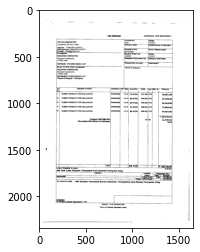

In [ ]:

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

#read your file
file=r'/content/In_2-1.jpg'
img = cv2.imread(file,0)
img.shape


#thresholding the image to a binary image

thresh,img_bin = cv2.threshold(img,160,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

cv2.imwrite('goodimage.png',img_bin)
#Plotting the image to see the output
plotting = plt.imshow(img_bin,cmap='gray')
plt.show()

In [ ]:
import requests


def ocr_space_file(filename, overlay=True, api_key='', language='eng'):
    payload = {'isOverlayRequired': overlay,
               'apikey': api_key,
               'language': language,
               }
    with open(filename, 'rb') as f:
        r = requests.post('https://api.ocr.space/parse/image',
                          files={filename: f},
                          data=payload,
                          )
    return r.content.decode()


def ocr_space_url(url, overlay=False, api_key='', language='eng'):
    
    payload = {'url': url,
               'isOverlayRequired': overlay,
               'apikey': api_key,
               'language': language,
               }
    r = requests.post('https://api.ocr.space/parse/image',
                      data=payload,
                      )
    return r.content.decode()


# Use examples:
test_file = ocr_space_file(filename='/content/goodimage.png', language='eng')
test_file

import json

PrettyJson = json.dumps(json.loads(test_file), indent=4, separators=(',', ': '), sort_keys=True)

print(str(test_file))

{"ParsedResults":[{"TextOverlay":{"Lines":[{"LineText":"TAX INVOICE","Words":[{"WordText":"TAX","Left":733.0,"Top":270.0,"Height":18.0,"Width":43.0},{"WordText":"INVOICE","Left":785.0,"Top":270.0,"Height":19.0,"Width":92.0}],"MaxHeight":19.0,"MinTop":270.0},{"LineText":"(ORIGINAL FOR RECIPIENT)","Words":[{"WordText":"(ORIGINAL","Left":1126.0,"Top":271.0,"Height":17.0,"Width":109.0},{"WordText":"FOR","Left":1244.0,"Top":272.0,"Height":15.0,"Width":45.0},{"WordText":"RECIPIENT)","Left":1296.0,"Top":272.0,"Height":19.0,"Width":123.0}],"MaxHeight":19.0,"MinTop":271.0},{"LineText":"VIRTUAI.COMPANYIND","Words":[{"WordText":"VIRTUAI.COMPANYIND","Left":196.0,"Top":337.0,"Height":14.0,"Width":203.0}],"MaxHeight":14.0,"MinTop":337.0},{"LineText":"VirtualAddr, 255.0.0.0, India","Words":[{"WordText":"VirtualAddr,","Left":196.0,"Top":363.0,"Height":17.0,"Width":94.0},{"WordText":"255.0.0.0,","Left":296.0,"Top":363.0,"Height":17.0,"Width":81.0},{"WordText":"India","Left":384.0,"Top":363.0,"Height":1